In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
x = torch.linspace(0,799,800)

In [3]:
y = torch.sin(x*2*3.1416/40)

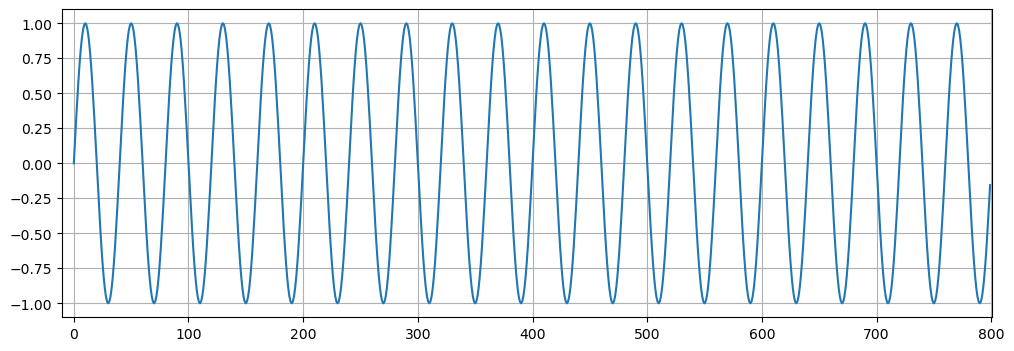

In [4]:
plt.figure(figsize=(12,4))
plt.xlim(-10, 801)
plt.grid(True)
plt.plot(y.numpy())

In [5]:
test_size = 40 # save 40 points for test set
train_set = y[:-test_size]
test_set = y[-test_size:]

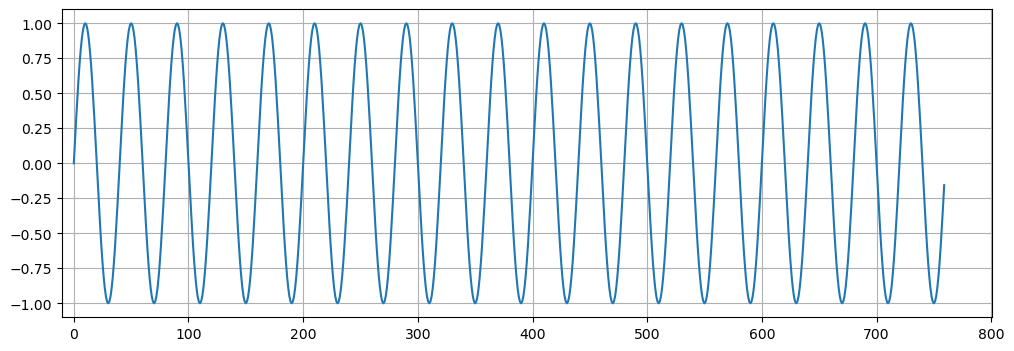

In [6]:
plt.figure(figsize=(12,4))
plt.xlim(-10, 801)
plt.grid(True)
plt.plot(train_set.numpy())

In [7]:
def input_data(seq, ws): # input: sequence and window_size
    out = [] # tuples ([0,1,2,3], [4]) ,([1,2,3,4], [5]), ...
    L = len(seq)

    for i in range(L-ws): # not entire L but L-ws in order to fit the last window and label (seq[i:i+ws], seq[i+ws:i+ws+1])
        window = seq[i:i+ws] # window is i up to i+window_size
        label = seq[i+ws:i+ws+1] # just 1 point in the future (one point after window)
        # i.e. data is [1,2,3,4,5,6,7,8,9,10], and ws = 5,
        # window is [1,2,3,4,5] and label is [6]
        out.append((window,label))
    
    return out

In [8]:
window_size = 40

train_data = input_data(train_set, window_size)

In [9]:
len(train_data)

720

In [10]:
# original data goes from 0 to 799 ---> 800 data points
# 800 - 40 (test size) ---> 760
# 760 - 40 (window size) ---> 720

In [11]:
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

In [12]:
train_data[1]

(tensor([ 1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,  7.0711e-01,
          8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,  1.0000e+00,
          9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,  7.0710e-01,
          5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01, -7.2400e-06,
         -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01, -7.0711e-01,
         -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01, -1.0000e+00,
         -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01, -7.0710e-01,
         -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01,  1.4480e-05]),
 tensor([0.1564]))

In [15]:
class LSTM(nn.Module):
    # (self, 1 y_val from timestamp (number of input feature), # of neurons, 1 prediction output)
    def __init__(self, input_size=1, hidden_size=50, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        self.linear = nn.Linear(hidden_size, out_size)

        # (Hidden state, Cell state)
        # torch.zeros(num_layer, batch_size (no. seq at a time), hidden_size)
        self.hidden = (torch.zeros(1,1,hidden_size), torch.zeros(1,1,hidden_size)) # hidden state, cell state

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden) # ((seq_len, batch_size, input_size), hidden)

        pred = self.linear(lstm_out.view(len(seq),-1)) # flatten across 2nd dim

        # [1,2,3] and predicted [4] ---> [1,2,3,4]
        return pred[-1] # only need last value

In [16]:
torch.manual_seed(42)
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [17]:
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [18]:
for param in model.parameters():
    print(param.numel())

200
10000
200
200
50
1
